<a href="https://colab.research.google.com/github/hijyun/2020-DDWU-Bigdata-idea-challenge/blob/master/Prediction/mapdata_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 패키지 설정

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from sklearn import datasets

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀

from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score  # ROC곡선 그리기

from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

In [20]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 데이터 읽기

In [3]:
df1 = pd.read_csv('https://raw.githubusercontent.com/hijyun/Overwatch-League-Prediction/main/preprocessing/e-sprot_data.csv')

In [4]:
X = df1.drop(['target'],axis=1)
y = df1['target']

In [5]:
df1.shape

(3632, 7)

In [6]:
df1.head()

,diff_att_pdistance,diff_def_pdistance,diff_att_time_b,diff_def_time_b,diff_att_control_p,diff_def_control_p,target
0,0.034546,-75.615051,125.750572,240.000000,0.0,0.0,1
1,0.000000,0.000000,11.693085,-224.587952,0.0,0.0,1
2,0.000000,0.000000,0.000000,0.000000,0.0,-165.0,1
3,0.014160,-75.549507,165.840027,0.000000,0.0,0.0,1
4,0.017067,-70.161865,186.312805,240.000000,0.0,0.0,1


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3632 entries, 0 to 3631
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   diff_att_pdistance  3632 non-null   float64
 1   diff_def_pdistance  3632 non-null   float64
 2   diff_att_time_b     3632 non-null   float64
 3   diff_def_time_b     3632 non-null   float64
 4   diff_att_control_p  3632 non-null   float64
 5   diff_def_control_p  3632 non-null   float64
 6   target              3632 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 198.8 KB


# 전처리 및 데이터 분할

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # 범주형 변수를 0부터 시작하는 정수형 숫자로 변환
y = le.fit_transform(y)


In [9]:
y

array([1, 1, 1, ..., 0, 0, 0])

## train data , test data split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1234, stratify=y)

# 모델

In [23]:
logistic = LogisticRegression(solver='liblinear',penalty='l2',C=0.1,random_state=1)
tree = DecisionTreeClassifier(max_depth=5,criterion='entropy',random_state=1)
knn = KNeighborsClassifier(n_neighbors=2,p=2,metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree), ('knn', knn)]

voting = VotingClassifier(estimators = voting_estimators,voting='soft')

forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)


adaboost = AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=300,
                                learning_rate = 0.01, 
                                random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(tree_method='hist',random_state=41)

clf_labels = ['Knn','Decision tree',  'Majority voting','Random forest','Ada boost','XGB','LIGHTGBM']

all_clf = [knn, tree, voting, forest,adaboost,xgb,lgb]

### AUC 검정

In [12]:
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
  % (scores.mean(), scores.std(), label))

ROC AUC: 0.899 (+/- 0.023) [Logistic regression]
ROC AUC: 0.966 (+/- 0.010) [Decision tree]
ROC AUC: 0.942 (+/- 0.018) [KNN]
ROC AUC: 0.973 (+/- 0.012) [Majority voting]
ROC AUC: 0.983 (+/- 0.006) [Random forest]
ROC AUC: 0.972 (+/- 0.008) [Ada boost]


### ROC 커브

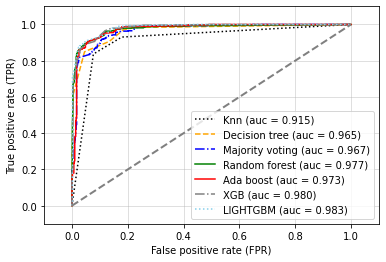

In [24]:
colors = ['black', 'orange', 'blue', 'green','red','gray','skyblue']
linestyles = [':', '--', '-.', '-','solid','dashdot','dotted']
for clf, label, clr, ls \
        in zip(all_clf, clf_labels, colors, linestyles):

  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr) # 교차검증 X
  plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
  
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
          linestyle='--',
          color='gray',
          linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

### 정오 분류표로 검정

In [14]:
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 106
정확도: 0.903
정밀도: 0.879
재현율: 0.908
F1: 0.894


# 튜닝

## adaboost

In [15]:
adaboost.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=5, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=1, splitter='best'),
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 5,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': 

In [17]:
parms = {'n_estimators': [100,200,300]
             }


grid = GridSearchCV(estimator=adaboost, 
                    param_grid=parms,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)

grid.fit(X_train,y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.3f %r" % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


0.981 +/- 0.004 {'n_estimators': 100}
0.975 +/- 0.004 {'n_estimators': 200}
0.972 +/- 0.004 {'n_estimators': 300}


In [18]:
print('최적의 파타미터: %s' % grid.best_params_)
print('ACU: %.3f' % grid.best_score_)

최적의 파타미터: {'n_estimators': 100}
ACU: 0.981


## voting

In [27]:
parms = {'logistic__C':[0.001,0.1,100.0],
         'tree__max_depth' :  [1,2,3,4,5],
         'knn__n_neighbors':[1,2,3,4,5]}


grid = GridSearchCV(estimator=voting, 
                    param_grid=parms,
                    cv=10,
                    scoring='roc_auc',
                    iid=False)


In [28]:
grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=10, error_score=nan,
             estimator=VotingClassifier(estimators=[('logistic',
                                                     LogisticRegression(C=100,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
                                                                        penalty='l2',
                       

In [29]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  print("%0.3f +/- %0.3f %r" % (grid.cv_results_['mean_test_score'][r],
        grid.cv_results_['std_test_score'][r] / 2.0,
        grid.cv_results_['params'][r]))


0.944 +/- 0.011 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 1}
0.948 +/- 0.011 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 2}
0.952 +/- 0.009 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 3}
0.966 +/- 0.007 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 4}
0.969 +/- 0.006 {'knn__n_neighbors': 1, 'logistic__C': 0.001, 'tree__max_depth': 5}
0.943 +/- 0.011 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 1}
0.948 +/- 0.011 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 2}
0.952 +/- 0.008 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 3}
0.966 +/- 0.007 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 4}
0.969 +/- 0.006 {'knn__n_neighbors': 1, 'logistic__C': 0.1, 'tree__max_depth': 5}
0.943 +/- 0.011 {'knn__n_neighbors': 1, 'logistic__C': 100.0, 'tree__max_depth': 1}
0.948 +/- 0.011 {'knn__n_neighbors': 1, 'logistic__C': 100.0, 'tree__max_depth': 2}
0.

In [30]:
print('최적의 파타미터: %s' % grid.best_params_)
print('ACU: %.3f' % grid.best_score_)


최적의 파타미터: {'knn__n_neighbors': 2, 'logistic__C': 0.1, 'tree__max_depth': 5}
ACU: 0.973
